Pour ce TP, nous utiliserons pytorch qui propose une API un peu plus user-friendly que celle de tensorflow v1

Commencez par installer pytorch_segmentation_model

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import torch
import segmentation_models_pytorch as smp
import torchsummary

Vous pouvez maintenant instancier une certains nombre d'architectures différentes de modèles de segmentation, visitez la [page du projet](https://github.com/qubvel/segmentation_models.pytorch) et essayer d'en instancier une en vous basant sur le modèle ci-dessous

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

Il peut aussi être utile de visualiser les idfférentes couches de son modèle, faites usage de la [documentation](https://github.com/sksq96/pytorch-summary) de summary pour afficher celles du modèle que vous avez choisi

In [ ]:
#your code here

Vous aurez aussi besoin d'un accés aux données pour l'entraînement, téléchargez les depuis ce [lien](https://drive.google.com/drive/folders/1_z6RfpDQNpPD6AE4Qa79bjsOhBwr1kwq?usp=sharing) et placez les dans votre google drive, puis utilisez le code ci-dessous pour y accéder

Vous pourrez explorer le drive depuis ce collab à l'aide d'un 

```
!dir /content/gdrive
```



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Vous pourrez ensuite charger les données à l'aide du code suivant

In [ ]:
import torch.utils.data as data
import cv2 as cv
import einops
import torch

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, img_files,mask_files):
        super(DataLoaderSegmentation, self).__init__()
        
        self.img_files =img_files
        self.mask_files=mask_files
        

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv.imread(img_path, cv2.IMREAD_GRAYSCALE)
            data = data.reshape((1,*data.shape))
            label =cv.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            label = (label>0)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

data_path = "/content/gdrive/My Drive/membrane"
img_dir_name = "train/image"
annotation_dir_name = "train/label"

train_path = os.path.join(data_path, img_dir_name)
anno_path = os.path.join(data_path, annotation_dir_name)
im_names = [os.path.join(train_path,iname) for iname in os.listdir(train_path)]
label_names = [os.path.join(anno_path,lname) for lname in os.listdir(anno_path)]
# data = DataSet(im_names,label_names)
train_loader = DataLoaderSegmentation(im_names,label_names)

Pour simplification, le code de model fitting est fourni ,et la function de calcul d'IOU est partiellement remplie. 

Tentez de finir la function de calcul IOU et d'implémenter celle de calcul de pixel_accuracy, faites attention aux dimensions et aidez vous du débugger `pb()` pour réaliser vos tests.

Pour rappel l'IOU d'une segmentation est données par les concepts de True positives et False positive tel que:

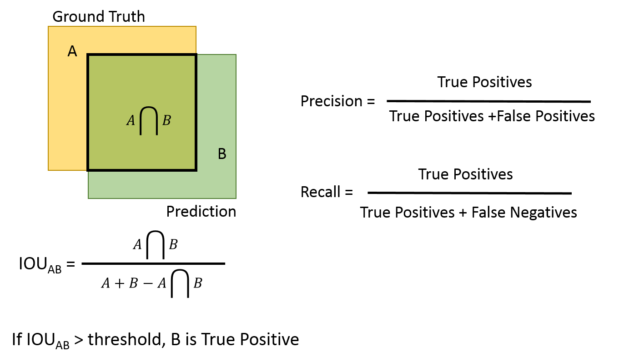

In [ ]:
from pdb import set_trace as pb


def pixel_accuracy(output, mask):
    with torch.no_grad():
        #your code here
    return accuracy


def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = torch.argmax(mask, dim=1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                #your code here
        return np.nanmean(iou_per_class)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


from pdb import set_trace as pb
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler,classes, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            mask_tiles = torch.nn.functional.one_hot(mask_tiles.to(torch.int64),classes).to(torch.float32).swapaxes(0,2)
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            image = image.reshape((1,*image.shape))
            mask = mask.reshape((1,*mask.shape))
            #forward
            output = model(image)
            loss = criterion(output[0], mask[0])
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data
                    mask_tiles = torch.nn.functional.one_hot(mask_tiles.to(torch.int64),classes).to(torch.float32).swapaxes(0,2)

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    image = image.reshape((1,*image.shape))
                    mask = mask.reshape((1,*mask.shape))
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output[0], mask[0])                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

Vous pouvez maintenant lancer votre entraînnement à l'aide des codes ci-dessous

In [ ]:
img_dir_name = "train/image"
annotation_dir_name = "train/label"

classes=2

train_path = os.path.join(data_path, img_dir_name)
anno_path = os.path.join(data_path, annotation_dir_name)
im_names = [os.path.join(train_path,iname) for iname in os.listdir(train_path)]
label_names = [os.path.join(anno_path,lname) for lname in os.listdir(anno_path)]
train_loader = DataLoaderSegmentation(im_names,label_names)

max_lr = 1e-3
epoch = 50
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, train_loader, criterion, optimizer, sched,classes=classes)

En vous aidant de la fonction de model fitting utilisée plus tôt, implémentez maintenant la fonction de prédiction des données (pas besoin de labels dans un contexte de prédictions)

In [ ]:
def predict(data):
  #your code here
  return output

image_tiles, mask_tiles = train_loader[0]
prediction = predict(image_tiles)

Enfin vous pourrez afficher les résultats de votre modèle avec le code ci-dessous

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow

prediction = torch.argmax(prediction,dim=1)
cv2_imshow(image[0,0].cpu().numpy())
cv2_imshow(output[0].cpu().numpy()*255)